# Prediction of Book Genre from a Summary using NLP
by Alexander White, January 2023
## Introduction

By training a Machine Learning (ML) model on a dataset of book summaries paired with the book's genres, we can use the model to suggest appropriate genres for a book based solely on its summary.

The dataset for this process was taken from Jasminyas' __[CMU Book Summary Dataset](https://www.kaggle.com/datasets/ymaricar/cmu-book-summary-dataset)__ on Kaggle, with the key values being the book genres and summaries. Both values were used to train the model.

This will allow entities such as editors and publishing companies to quickly anticipate the target market for any book for which a summary is available. While further work is outside of the scope of this project, such a model could be easily expanded to provide a host of other novel features such as tone and sentiment analysis, formatting, or even plot summarization.

## Data Exploration
### Acquisition and Loading
Here we take the data from Jasminyas' __[CMU Book Summary Dataset](https://www.kaggle.com/datasets/ymaricar/cmu-book-summary-dataset)__ on Kaggle and load it into a pandas dataframe for processing.

In [1]:
# imports

# data basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
import re
import json
from string import punctuation

# NLP
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

# ML modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, KFold

# utility
from IPython.display import clear_output
from datetime import datetime
from pprint import pprint
import pickle

# global values
random_seed = 42 # for analysis reproducibility
path_to_data = "../Data/booksummaries.txt" # starting "CMU Book Summary Dataset" dataset

In [2]:
# import data into local dataframe
col_names = [
    "wikipedia_article_id",
    "freebase_id",
    "book_title",
    "author",
    "publication_date",
    "book_genres",
    "plot_summary"
]
df = pd.read_csv(path_to_data, sep="\t", names=col_names)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   wikipedia_article_id  16559 non-null  int64 
 1   freebase_id           16559 non-null  object
 2   book_title            16559 non-null  object
 3   author                14177 non-null  object
 4   publication_date      10949 non-null  object
 5   book_genres           12841 non-null  object
 6   plot_summary          16559 non-null  object
dtypes: int64(1), object(6)
memory usage: 905.7+ KB
None


,wikipedia_article_id,freebase_id,book_title,author,publication_date,book_genres,plot_summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


### Initial Observations

There are 16559 rows in this dataset, though only 12841 have our target variable of book_genres. The wikipedia_article_id and freebase_id columns refer to the initial source of the information. There are 2382 null values in the author column, so not all books have authorial attribution. The publication_date column appears to vary in composition by specificity and contain 5610 null values. All columns other than plot_summary (our variable) and book_genres (our target) are unnecessary for this analysis, but could be maintained to provide context.

The book_genres column is formatted in a dictionary of (freebase_id: genre_name) tuples for each book. For example, Animal Farm has the genres {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt": "Satire", "/m/0dwly": "Children's literature", "/m/014dfn": "Speculative fiction", "/m/02xlf": "Fiction"}. The values look odd, so we will drill more into the genres.

The plot_summary column is a single string with the entire plot summary extracted from Wikipedia.

In [3]:
# look at an example as-is
tmp = df.book_genres[0] # get the first entry from the dataset
print(tmp)
print("Object type: {}".format(type(tmp)))

{"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt": "Satire", "/m/0dwly": "Children's literature", "/m/014dfn": "Speculative fiction", "/m/02xlf": "Fiction"}
Object type: <class 'str'>


Even though they look like dictionaries, pandas imported the genres as strings. They need to be separate for the analysis, so we will now break them into lists of genre names. This will be done again later in the pre-processing stage, but will help provide context for the exploration now.

In [4]:
# Define a function to rearrange genre dictionaries formatted as strings into lists of names only
def genre_dict_to_list(dict_string):
    """Take a string representation of a dictionary and return a list of the values."""
    try:
        genre_dict = json.loads(dict_string)
        return list(genre_dict.values())
    except:
        return None

# create a new series with a list of genre names for each book
genres = df['book_genres'].apply(genre_dict_to_list)
genres.dropna(inplace=True) # drop null values

# explode series so each genre is on its own row
genres = genres.explode(ignore_index=True)

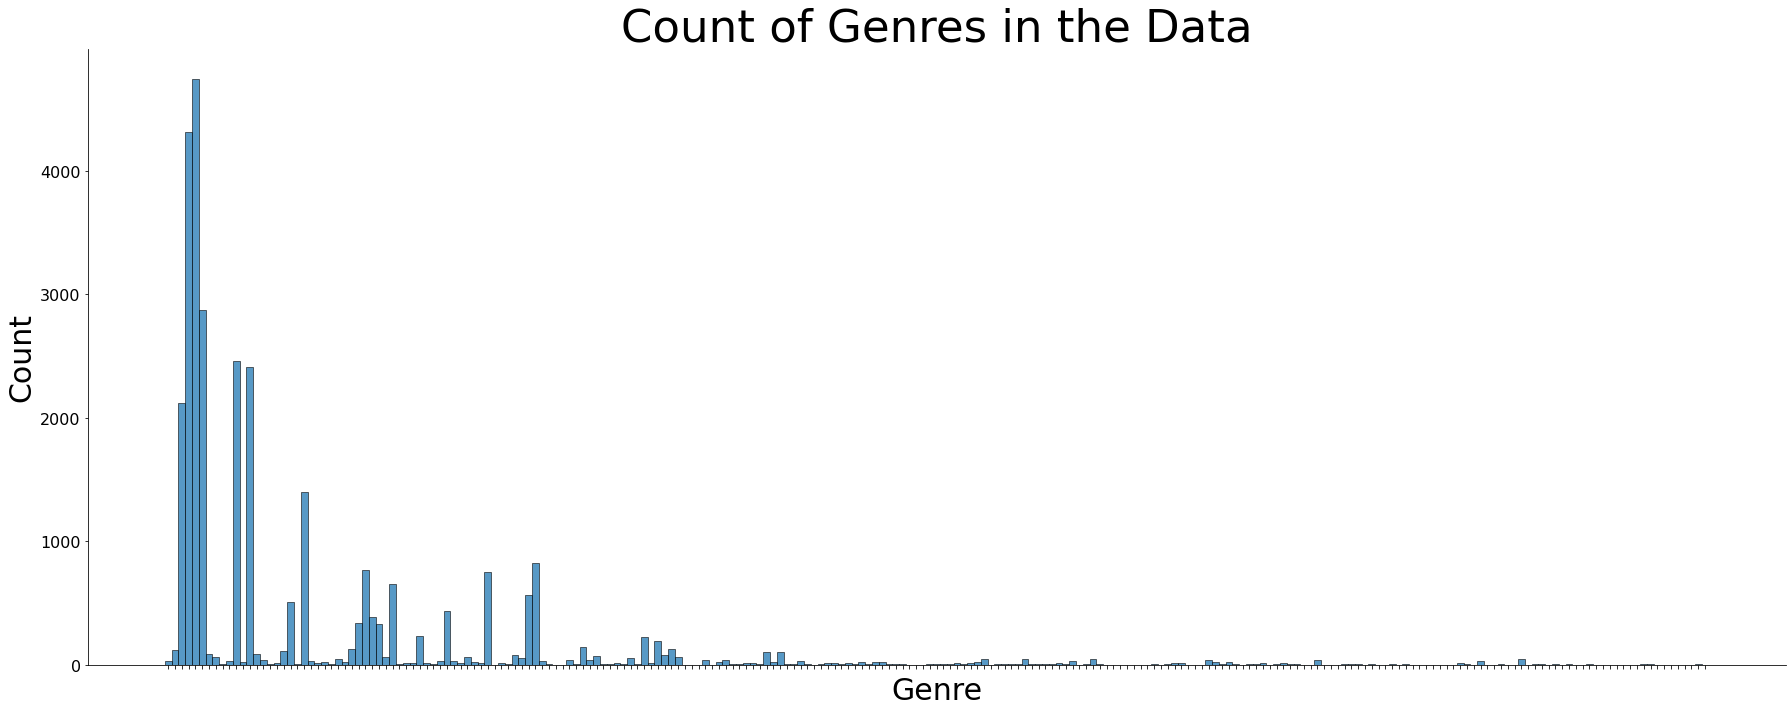

Fiction                4747
Speculative fiction    4314
Science Fiction        2870
Novel                  2463
Fantasy                2413
                       ... 
Pastiche                  1
Marketing                 1
Anti-nuclear              1
Fictional crossover       1
Collage                   1
Name: book_genres, Length: 227, dtype: int64


In [5]:
# plot a histogram of genre occurrence in the dataset
fig = plt.figure(figsize=(25,10))
chart = sns.histplot(data=genres)

# make it pretty
chart.set(xticklabels=[]) # remove x labels since they would be too small to use
plt.title('Count of Genres in the Data', fontsize=45)
plt.xlabel('Genre', fontsize=30)
plt.ylabel('Count', fontsize=30)
plt.yticks(fontsize=16)
ax = plt.gca() # remove top and right border lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
plt.show();
print(genres.value_counts()) # numeric view of the chart results

Clearly, the data is unbalanced with respect to genre. There are some genres that are over-represented and many that are almost nonexistent. We can reduce the effect this will have on our final model by limiting the set to only genres with sufficient representation before processing. For our purposes, genres with more than 500 samples should work. These will eventually be the genres the ML model can predict.

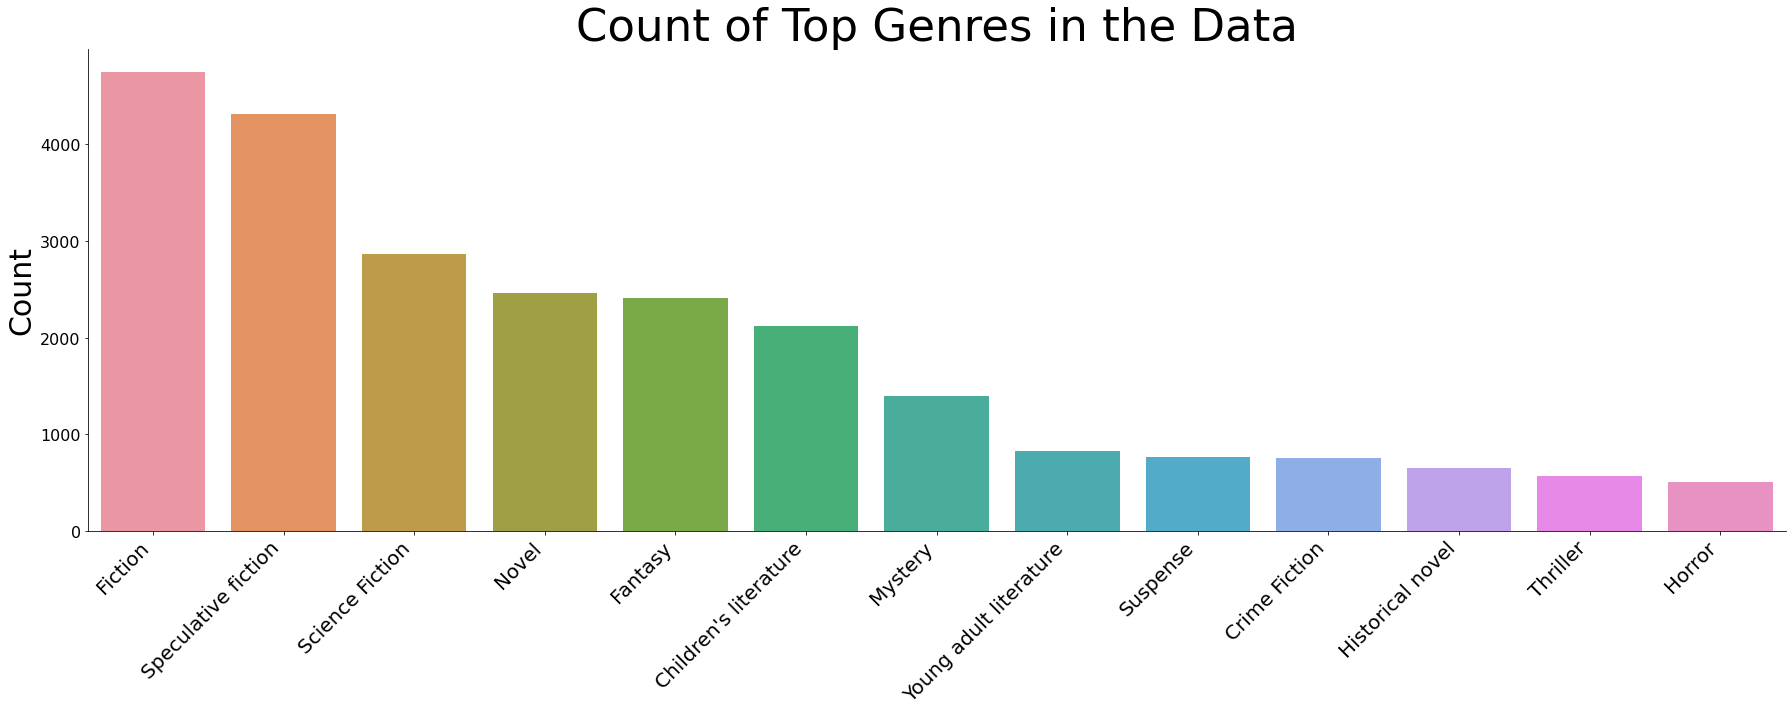

In [6]:
min_samples = 500 # set the minimum allowable sample size

# genres with more than the required number of samples
top_genres = genres.value_counts()[genres.value_counts() > min_samples] # we will use this again later during cleaning

# plot a histogram of genre occurrence in the dataset
fig = plt.figure(figsize=(25,10))
chart = sns.barplot(x=top_genres.index, y=top_genres.values)

# make it pretty
plt.title('Count of Top Genres in the Data', fontsize=45)
plt.ylabel('Count', fontsize=30)
plt.yticks(fontsize=16)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='20'
    
)
# remove top and right border lines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
plt.show();
# print(genres.value_counts()[genres.value_counts() > min_samples])

This will be a much more balanced dataset and should give superior results.

## Data Preparation

#### Overview
Having explored the data, we can now begin cleaning it for use in our model. This will involve...
1. Dropping rows null in book_genres and removing unneeded columns (except title, which will add context to the results)
2. Breaking the book_genres column into its components for each book (like earlier)
3. Cleaning the summaries
    - making all words lower-case
    - removing punctuation
    - remove digits
    - removing stopwords
    - tagging with parts of speech
    - lemmatizing
4. Exploding the frame so that each book has information on each genre
5. Drop rows with genres not in the top list generated earlier
6. Creating a Bag of Words for modeling
7. Creating TF-IDF data for modeling

### Cleaning
For our cleaning, we need to reduce the impact of word variance as much as possible before we make our bags of words and TF-IDF data. To do this, we will make everything lower-case and eliminate punctuation, remove stopwords, then tag and lemmatize the words.

Below we define a function for cleaning text. This will take an entire summary and break it into sentences, then make each sentence lowercase, remove all punctuation, define the parts of speech, and lemmatize the individual words. Finally, it will combine the lemmatized words into a new string representing the cleaned summary.

In [7]:
# functions and variables for use in cleaning
en_stopwords = stopwords.words('english')
wnl = WordNetLemmatizer()

# Define function for mapping wordnet part of speech tags to treebank tags used by NLTK pos_tag
def get_wordnet_pos(treebank_tag):
    """Map wordnet part of speech tags to treebank tags used by NLTK pos_tag.
    
    Input: treebank_tag -- a string treebank_tag from NLTK's pos_tag
    Return: wordnet part of speech for use with NLTk's lemmatizer
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN # default pos

# define function for cleaning summaries
def clean_text(text):
    """Clean a text string by making it lower-case, removing punctuation, digits, and stopwords, then lemmatizing it."""
    results = []
    # split text into sentences
    sentences = sent_tokenize(text)
    # clean and lemmatize each sentence
    for sentence in sentences:
        words = sentence.lower() # shift to lowercase
        words = re.sub(f"[{re.escape(punctuation)}]", "", words) # remove punctuation
        words = re.sub("[0-9]", "", words) # remove digits
        words = word_tokenize(words) # split sentence into individual words
        words = [word for word in words if not word in en_stopwords] # remove stopwords
        parts = pos_tag(words)
        for word, part in parts:
            lemma = wnl.lemmatize(word, pos=get_wordnet_pos(part))
            results.append(lemma)
    return " ".join(results)

In [8]:
# drop unnecessary columns
columns_to_drop = ['wikipedia_article_id', 'freebase_id', 'author', 'publication_date']
clean_df = df.drop(columns=columns_to_drop).copy()
print("Initial length = {}".format(len(clean_df)))

#drop rows without genre data
clean_df.dropna(subset=['book_genres'], inplace=True)
print("Cleaned length = {} (all null genre rows removed)".format(len(clean_df)))

# a sample of the first summary before cleaning
print("\n[First summary before cleaning]\n", clean_df.iloc[0].plot_summary[:250], "...\n")

# clean the summaries
# this will have to be done in chunks as it is computationally expensive and takes a good deal of time
increment = 500 # how many rows to process at once
start = datetime.now()
clean_summaries = pd.DataFrame()
for i in range(0, len(clean_df), increment):
    print("Processing {}-{} of {}.\nTotal Time Elapsed: {} seconds"\
          .format(i, i+increment-1, len(clean_df)-1, (datetime.now()-start).total_seconds()))
    next_set = clean_df.iloc[i:i+increment]['plot_summary'].apply(clean_text)
    clean_summaries = pd.concat((clean_summaries, next_set))
    # uncomment the next two rows for live feedback on the cleaning process
#     clear_output()
#     print("Last processed: {}\n".format(clean_summaries.iloc[-1:]))
clean_df['summary'] = clean_summaries
clean_df.drop(columns=['plot_summary'], inplace=True) # replace uncleaned summary with cleaned summary
print("Summary cleaning complete.")

# a sample of the first summary after cleaning
print("\n[First summary after cleaning]\n", clean_df.iloc[0].summary[:250], "...\n")

# transform genres into lists of names
clean_df['genre'] = df['book_genres'].apply(genre_dict_to_list)
clean_df.drop(columns=['book_genres'], inplace=True) # replace uncleaned genres with cleaned genres

# explode each genre into its own row
clean_df = clean_df.explode(column='genre', ignore_index=True)

# drop rows for genres not in our top list from earlier
top_genres_list = list(top_genres.index) # the top genres identified in our exploration; all have more than 500 samples
clean_df = clean_df[clean_df['genre'].isin(top_genres_list)].copy()
clean_df.reset_index(drop=True, inplace=True)
    
print(clean_df.info())
clean_df.head()

Initial length = 16559
Cleaned length = 12841 (all null genre rows removed)

[First summary before cleaning]
  Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napole ...

Processing 0-499 of 12840.
Total Time Elapsed: 0.001483 seconds
Processing 500-999 of 12840.
Total Time Elapsed: 19.042724 seconds
Processing 1000-1499 of 12840.
Total Time Elapsed: 34.486119 seconds
Processing 1500-1999 of 12840.
Total Time Elapsed: 48.513976 seconds
Processing 2000-2499 of 12840.
Total Time Elapsed: 61.871008 seconds
Processing 2500-2999 of 12840.
Total Time Elapsed: 74.170408 seconds
Processing 3000-3499 of 12840.
Total Time Elapsed: 85.235827 seconds
Processing 3500-3999 of 12840.
Total Time Elapsed: 95.824384 seconds
Processing 4000-4499 of 12840.
Total Time Elapsed: 106.061444 seconds
Processing 4500-499

,book_title,summary,genre
0,Animal Farm,old major old boar manor farm call animal farm...,Children's literature
1,Animal Farm,old major old boar manor farm call animal farm...,Speculative fiction
2,Animal Farm,old major old boar manor farm call animal farm...,Fiction
3,A Clockwork Orange,alex teenager live nearfuture england lead gan...,Science Fiction
4,A Clockwork Orange,alex teenager live nearfuture england lead gan...,Speculative fiction


### Creating a Bag of Words
With our data clean, we are ready to build our Bag of Words and TF-IDF datasets for modeling and analysis.

A Bag of Words is the count of each word used in the test. Analyses done with the BoW approach are naive to word order effects. The classic example here is that the phrases "the dog chased the cat" and "the cat chased the dog" both process the same, so meaning is lost in the translation. However, it is still useful for NLP as there is much information to be gleaned simply from word counts.

In [9]:
vectorizer = CountVectorizer() # using default settings
bag_of_words = vectorizer.fit_transform(clean_df['summary']) # fit it on our data and build sparse word count array

### Creating Term Frequency - Inverse Document Frequency Data
As another input, we will test the performance of our model with both TF-IDF and Bag of Words data. Let's assemble the TF-IDF data now.

In [10]:
tfidf_vectorizer = TfidfVectorizer() # using default settings
tfidf = tfidf_vectorizer.fit_transform(clean_df['summary']) # fit it on our data and build sparse TF-IDF array

## Modeling
Now that the data has been pre-processed and is in machine readable forms, we can build and train our model. We will do this two ways with each data preparation to compare performance.
- CNB with Bag of Words
- CNB with TF-IDF
- MNB with Bag of Words
- MNB with TF-IDF
- Other models exist, but were outside of the scope of this examination.

### Complement Naive Bayes
Complement Naive Bayes is an adaptation of the Multinomial Naive Bayes model which often achieves good results in NLP. From __[scikit-learn's description](https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes)__, "CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets." This makes it well suited for our data. It functions by calculating the probability that a given item does not belong to each class in a set, then selecting the class to which it is <i>least</i> likely to <i>not</i> belong...which is a convoluted way of saying that it's the least likely that this item was not part of that set.

The Multinomial Naive Bayes is the standard for text classification, so we will also examine that later.

For our analysis, X will be our processed summaries, either as a Bag of Words or as a TF-IDF array. We will run both models one with each before selecting a final model. Similarly, our y will be the genre (encoded as a number for easier processing). Thus, we are trying to predict the genre by our summary text.

In [11]:
# encode genres into labels and make X and y
le = LabelEncoder()

y_names = clean_df['genre']
y = le.fit_transform(y_names)

X = tfidf # based on our summary texts
Xalt = bag_of_words # for our alternative analyses

# split our data into training and test sets
# Under normal circumstances, this might need to happen before bagging and tf-idf to verify pure results, but
# it should be fine for our purposes here.
split_test_ratio = 0.3
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=split_test_ratio, random_state=random_seed) # from our TF-IDF data

Xalt_train, Xalt_test, yalt_train, yalt_test = \
train_test_split(X, y, test_size=split_test_ratio, random_state=random_seed) # from our BoW data

In [12]:
# create CNB model
cnb = ComplementNB() # default settings
cnb.fit(X_train, y_train) # fit our TF-IDF data

cnb_alt = ComplementNB()
cnb_alt.fit(Xalt_train, yalt_train) # fit our BoW data

# make predictions
cnb_train_preds = cnb.predict(X_train) # predict from our TF-IDF data
cnb_test_preds = cnb.predict(X_test)

alt_cnb_train_preds = cnb_alt.predict(Xalt_train) # predict from our BoW data
alt_cnb_test_preds = cnb_alt.predict(Xalt_test)

# see how they stack up
print(f"TF-IDF Training Set Accuracy : {accuracy_score(y_train, cnb_train_preds) * 100} %")
print(f"TF-IDF Test Set Accuracy : {accuracy_score(y_test, cnb_test_preds) * 100} % \n")
print(f"TF-IDF Classifier Report : \n\n {classification_report(y_test, cnb_test_preds, target_names=le.classes_)}")
print(f"\nBag of Words Training Set Accuracy : {accuracy_score(yalt_train, alt_cnb_train_preds) * 100} %")
print(f"Bag of Words Test Set Accuracy : {accuracy_score(yalt_test, alt_cnb_test_preds) * 100} % \n")
print(f"Bag of Words Classifier Report : \n\n {classification_report(yalt_test, alt_cnb_test_preds, target_names=le.classes_)}")

TF-IDF Training Set Accuracy : 50.99531615925058 %
TF-IDF Test Set Accuracy : 15.24381915038929 % 

TF-IDF Classifier Report : 

                         precision    recall  f1-score   support

 Children's literature       0.15      0.09      0.11       619
         Crime Fiction       0.15      0.06      0.08       241
               Fantasy       0.14      0.11      0.13       713
               Fiction       0.17      0.33      0.22      1454
      Historical novel       0.26      0.09      0.13       219
                Horror       0.10      0.03      0.04       147
               Mystery       0.15      0.10      0.12       431
                 Novel       0.16      0.07      0.10       705
       Science Fiction       0.23      0.23      0.23       881
   Speculative fiction       0.09      0.12      0.10      1262
              Suspense       0.00      0.00      0.00       235
              Thriller       0.03      0.01      0.01       173
Young adult literature       0.16    

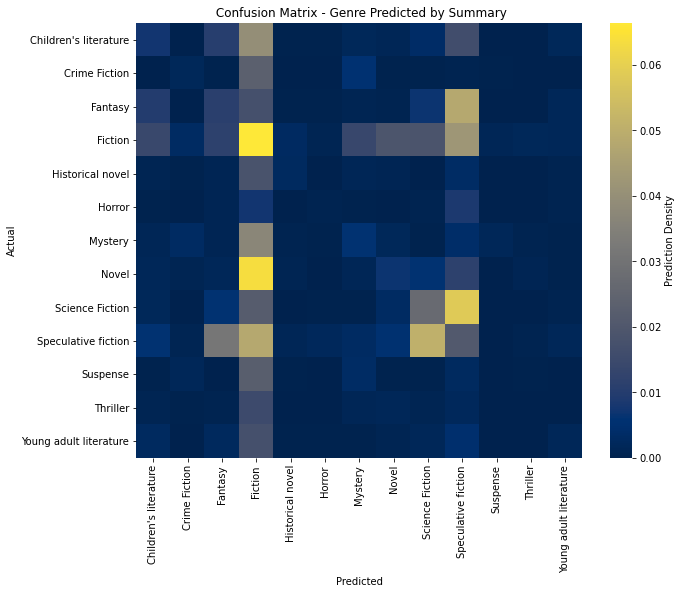

In [13]:
# heatmap of the confusion matrix
matrix = metrics.confusion_matrix(y_test, cnb_test_preds, normalize='all')
confusion_df = pd.DataFrame(matrix, index=le.classes_, columns=le.classes_)
fig = plt.figure(figsize=(10, 8))
chart = sns.heatmap(confusion_df, cmap='cividis', cbar_kws={'label': 'Prediction Density'})
# formatting
plt.title(' Confusion Matrix - Genre Predicted by Summary')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

From the numbers, both the TF-IDF data and the Bag of Words data give the same result suggesting that the processing is unimportant to a machine learning model.

Also, the accuracy of both models was <u>abysmal</u>. This suggests that there are serious issues with our underlying data or assumptions, or that our model needs to be tuned. Before that, though, let's have a look at the other normal model--the Multinomial Naive Bayes.

### Alternative Model: Multinomial Naive Bayes
As the standard choice for text analysis, the Multinomial Naive Bayes has similar assumptions to the Complement Naive Bayes but tends to function more poorly under imbalanced conditions.

In [14]:
# create MNB model
mnb = MultinomialNB() # default settings
mnb.fit(X_train, y_train) # fit our TF-IDF data

mnb_alt = ComplementNB()
mnb_alt.fit(Xalt_train, yalt_train) # fit our BoW data

# make predictions
mnb_train_preds = mnb.predict(X_train) # predict from our TF-IDF data
mnb_test_preds = mnb.predict(X_test)

alt_mnb_train_preds = mnb_alt.predict(Xalt_train) # predict from our BoW data
alt_mnb_test_preds = mnb_alt.predict(Xalt_test)

# see how they stack up
print(f"TF-IDF Training Set Accuracy : {accuracy_score(y_train, mnb_train_preds) * 100} %")
print(f"TF-IDF Test Set Accuracy : {accuracy_score(y_test, mnb_test_preds) * 100} % \n")
print(f"TF-IDF Classifier Report : \n\n {classification_report(y_test, mnb_test_preds, target_names=le.classes_)}")
print(f"\nBag of Words Training Set Accuracy : {accuracy_score(yalt_train, alt_mnb_train_preds) * 100} %")
print(f"Bag of Words Test Set Accuracy : {accuracy_score(yalt_test, alt_mnb_test_preds) * 100} % \n")
print(f"Bag of Words Classifier Report : \n\n {classification_report(yalt_test, alt_mnb_test_preds, target_names=le.classes_)}")

TF-IDF Training Set Accuracy : 29.250585480093676 %
TF-IDF Test Set Accuracy : 21.40417975686382 % 

TF-IDF Classifier Report : 

                         precision    recall  f1-score   support

 Children's literature       0.00      0.00      0.00       619
         Crime Fiction       0.00      0.00      0.00       241
               Fantasy       0.12      0.00      0.00       713
               Fiction       0.21      0.72      0.33      1454
      Historical novel       0.00      0.00      0.00       219
                Horror       0.00      0.00      0.00       147
               Mystery       0.00      0.00      0.00       431
                 Novel       0.00      0.00      0.00       705
       Science Fiction       0.24      0.01      0.01       881
   Speculative fiction       0.22      0.41      0.29      1262
              Suspense       0.00      0.00      0.00       235
              Thriller       0.00      0.00      0.00       173
Young adult literature       0.00   

C:\Users\alexwhite2\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


However, our numbers are very similar to those from the CMB analyses. In fact, the test score of our MNB TF-IDF model seems to be higher than that of our CMB TF-IDF model, though that is likely the result of chance more than model superiority, given the lower training accuracy of the former.

## Evaluation
Based on the numbers from our exploratory modeling, we can expect TF-IDF and Bag of Words sets to perform similarly under both CMB and MNB models. Let's tune our CMB model using TF-IDF data, then, and see how it does under validation.

In [23]:
# hyperparameters for grid_search tuning with alpha and k-fold validation
param_grid_nb = {
    'alpha' : np.geomspace(0.1, 100, num=1000) # search possible alpha values from 0-100, weighting values closer to 0 higher
}
num_splits = 10 # for k-fold validation

# create CNB model grid with k-fold validation
cnb_grid = GridSearchCV(estimator=ComplementNB(), 
                        param_grid=param_grid_nb, 
                        verbose=1, 
                        cv=KFold(n_splits=num_splits, shuffle=True, random_state=random_seed),
                        n_jobs=-1,
                        return_train_score=True
                       )
cnb_grid.fit(X_train, y_train) # fit our TF-IDF data

print(cnb_grid.best_estimator_)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000

ComplementNB(alpha=97.94696670695396)


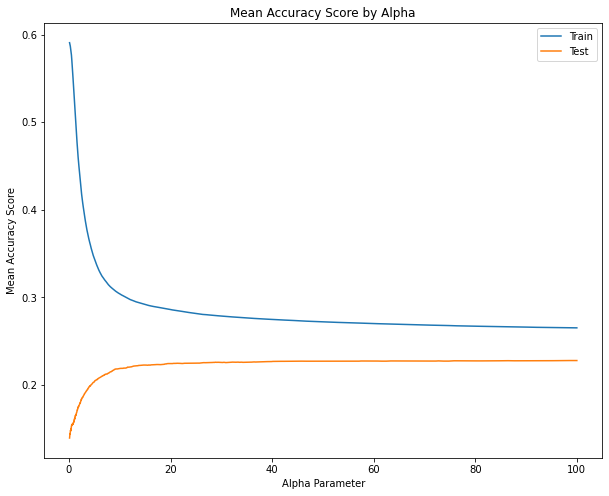

In [46]:
cv_df = pd.DataFrame(cnb_grid.cv_results_)
fig = plt.figure(figsize=(10, 8))
sns.lineplot(
    data=cv_df[['param_alpha', 'mean_train_score', 'mean_test_score']], 
    x='param_alpha', 
    y='mean_train_score')
sns.lineplot(
    data=cv_df[['param_alpha', 'mean_train_score', 'mean_test_score']], 
    x='param_alpha', 
    y='mean_test_score', )
plt.ylabel('Mean Accuracy Score')
plt.xlabel('Alpha Parameter')
plt.title("Mean Accuracy Score by Alpha")
plt.legend(['Train', 'Test'])
plt.show();

It looks like, from a range of 0.1-100, an alpha of ~98 will give us the best results with our data. However, there is a notable inverse relationship between traiing and testing accuracy. This suggests that our model may not be the best choice for this data.

In [16]:
train_preds = cnb_grid.predict(X_train)
preds = cnb_grid.predict(X_test)
# see how they stack up
print(f"Grid Training Accuracy : {accuracy_score(y_train, train_preds) * 100} %")
print(f"Grid Test Accuracy : {accuracy_score(y_test, preds) * 100} % \n")
print(f"Grid Classifier Report : \n\n {classification_report(y_test, preds, target_names=le.classes_)}")

Grid Training Accuracy : 26.23536299765808 %
Grid Test Accuracy : 22.852069389427673 % 

Grid Classifier Report : 

                         precision    recall  f1-score   support

 Children's literature       0.00      0.00      0.00       619
         Crime Fiction       0.00      0.00      0.00       241
               Fantasy       0.00      0.00      0.00       713
               Fiction       0.22      0.78      0.34      1454
      Historical novel       0.00      0.00      0.00       219
                Horror       0.00      0.00      0.00       147
               Mystery       0.00      0.00      0.00       431
                 Novel       0.00      0.00      0.00       705
       Science Fiction       0.77      0.01      0.02       881
   Speculative fiction       0.26      0.42      0.32      1262
              Suspense       0.00      0.00      0.00       235
              Thriller       0.00      0.00      0.00       173
Young adult literature       0.00      0.00      0

C:\Users\alexwhite2\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


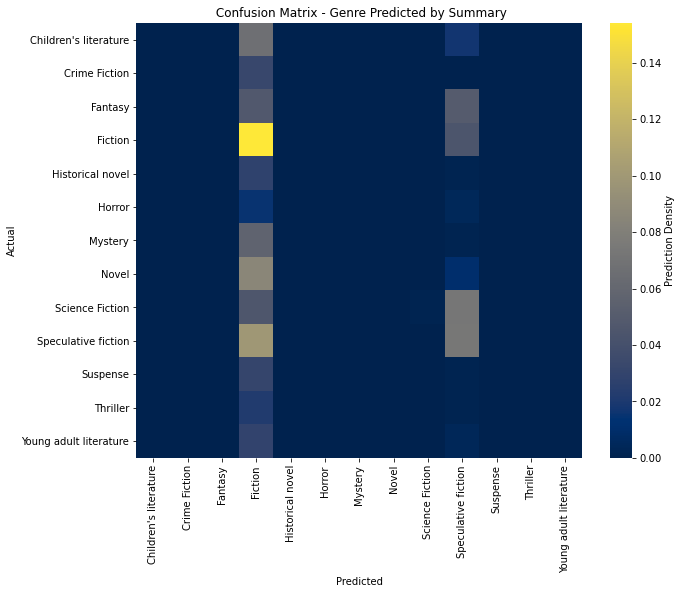

In [17]:
# heatmap of the confusion matrix
matrix = metrics.confusion_matrix(y_test, preds, normalize='all')
confusion_df = pd.DataFrame(matrix, index=le.classes_, columns=le.classes_)
fig = plt.figure(figsize=(10, 8))
chart = sns.heatmap(confusion_df, cmap='cividis', cbar_kws={'label': 'Prediction Density'})
# formatting
plt.title(' Confusion Matrix - Genre Predicted by Summary')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Well, that does not help. Because of the imbalance in the dataset, the model learned that by just guessing Fiction or Speculative Fiction under most circumstances, it would be right. While the absolute accuracy of the model is indeed higher, it loses all of the value we hoped to gain from it. Instead, the earlier model is to be preferred.

While the accuracy of our first Complement Naive Bayes model was underwhelming, it did a better job of spreading its guesses around, which is more useful for our purposes. Even if it guessed Fiction more often than it should, it still at least tried with the other genres.

The first model will be our working model, then.

In [20]:
# pickle model for future use
path_to_save = "../Data/pickles/trained_cnb.dat"
with open (path_to_save, "w+b") as f:
    pickle.dump(cnb, f)
print(f"Pickling complete. Model saved to {path_to_save}.")

Pickling complete. Model saved to ../Data/pickles/trained_cnb.dat.


## Conclusion
By using Natural Language Processing techniques such as Term Frequency - Inverse Document Frequency on our cleaned dataset, we were able to train a Complement Naive Bayes machine learning model to predict the genre of a book given its summary. Our accuracy was significantly below what could be hoped, but that is probably a multifaceted issue which could be excellent grounds for further research. Interestingly, our data was skewed in such a way that higher training validation for our model equated to less interesting performance. The absolute accuracy of the model was higher, but only because the model over-guessed the more prominent genres and neglected the less prominent ones.

#### Limitations
This model has some severe limitations in its current form. First, the accuracy of its predictions is <25% for any genre. This is still better than randomly guessing would give, but nowhere near the desired levels. Human prediction is still far superior to the current model. Second, our model was trained in a context unaware manner, so much of the contextual meaning was lost. This might have been a contributing factor to our low accuracy rate. Third, it only works for English language texts, since that was the overwhelming majority of words present in the summaries. Finally, the model can only predict one genre for a summary. In the real world, books are commonly assigned many different genres. Thus, even "correct" predictions should be taken with the understanding that they are still lacking.

Many of these limitations could be overcome with more time, effort, and material. More data points would help strengthen the model's predictive power. These could be procured (by expanding the data) or engineered (by generating similar summaries). We could also expand our Bag of Words or TF-IDF approaches to consider dyads, which would start to incorporate context into the prediction. From there, it would be interesting to choose a different modeling tool which was designed to handle multiple categories for each item. This could be a tremendous boon to the model as it would eliminate much of the uncertainty which is likely a part of the current model due to repeated texts.

Regardless of the avenue, the future is full of possibilities for models such as this. Genre prediction is only the tip of the proverbial iceberg of capabilities. Indeed, one might even say that our society is turning the page on machine learning models and the future is yet unwritten.